In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from keras.models import Model, Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Dense, Reshape, Dropout, Activation
from keras.layers import Input, BatchNormalization
from keras.losses import mean_squared_error, categorical_crossentropy
from keras.optimizers import Adam
from keras.utils import plot_model, multi_gpu_model

from utils import LossHistory, plotHistory, visualization_train, visualization_data, rotation_accuracy
from keras_capsnet.layer.capsnet import PrimaryCaps, Caps, ClassesCaps, Mask
from keras_capsnet.losses import margin
from keras_capsnet.activations import squash
from datasets.mnist import dataGenerator

Using TensorFlow backend.


In [2]:
# Plotting for dark theme
sns.set(context='paper', style='darkgrid', rc={'figure.facecolor':'white'}, font_scale=1.2)

# Parameters

In [3]:
num_class = 10
input_shape = (28, 28, 1)
m_train = 60000
m_test = 10000

batch_size = 16

data_augmentation = {
    'width_shift_range': 2,
    'height_shift_range': 2
}

# Dataset

In [4]:
trainGenerator = dataGenerator('train', batch_size=batch_size, reshape=False, **data_augmentation)
testGenerator = dataGenerator('test', batch_size=batch_size, reshape=False)

11493376/11490434 [==============================] - 0s 0us/step


# Model

In [5]:
model = Sequential([
    Convolution2D(filters=256, kernel_size=(9, 9), strides=1, padding='valid', activation='relu', input_shape=input_shape),
    PrimaryCaps(capsules=32, capsule_dim=8, kernel_size=(9, 9), strides=2, padding="valid", activation_caps=squash),
    Caps(capsules=num_class, capsule_dim=16, routings=3, activation_caps=squash),
    ClassesCaps(name='capsule'),
])

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 20, 256)       20992     
_________________________________________________________________
primary_caps_1 (PrimaryCaps) (None, 1152, 8)           5308672   
_________________________________________________________________
caps_1 (Caps)                (None, 10, 16)            1474560   
_________________________________________________________________
capsule (ClassesCaps)        (None, 10)                0         
Total params: 6,804,224
Trainable params: 6,804,224
Non-trainable params: 0
_________________________________________________________________


# Training

In [7]:
model.compile(optimizer=Adam(lr=1e-4),
              loss=margin(),
              metrics={'capsule': 'categorical_accuracy'})

In [8]:
hist = model.fit_generator(trainGenerator,
                           steps_per_epoch=trainGenerator.n // trainGenerator.batch_size,
                           epochs=5,
                           validation_data=testGenerator,
                           validation_steps=testGenerator.n // testGenerator.batch_size,
                           workers=4,
                           verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
3750/3750 [==============================] - 368s 98ms/step - loss: 0.0757 - categorical_accuracy: 0.9319 - val_loss: 0.0248 - val_categorical_accuracy: 0.9836
Epoch 2/5
3750/3750 [==============================] - 342s 91ms/step - loss: 0.0248 - categorical_accuracy: 0.9822 - val_loss: 0.0146 - val_categorical_accuracy: 0.9895
Epoch 3/5
3750/3750 [==============================] - 342s 91ms/step - loss: 0.0179 - categorical_accuracy: 0.9871 - val_loss: 0.0139 - val_categorical_accuracy: 0.9908
Epoch 4/5
3750/3750 [==============================] - 341s 91ms/step - loss: 0.0145 - categorical_accuracy: 0.9897 - val_loss: 0.0100 - val_categorical_accuracy: 0.9931
Epoch 5/5
3750/3750 [==============================] - 342s 91ms/step - loss: 0.0124 - categorical_accuracy: 0.9910 - val_loss: 0.0093 - val_categorical_accuracy: 0.9939


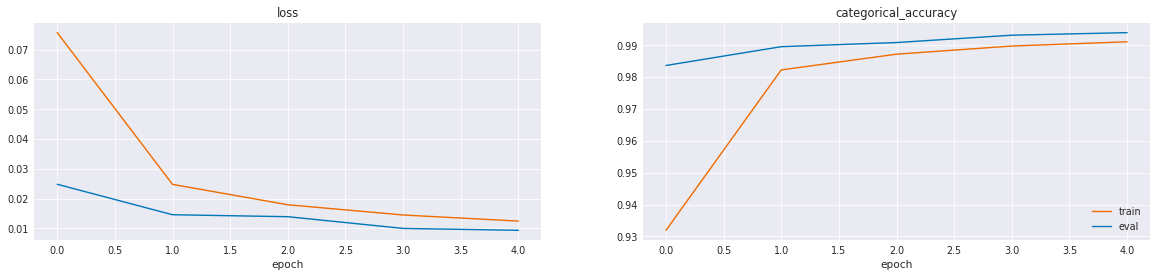

In [9]:
plotHistory(hist.history)
plt.savefig('mnist.png')